In [ ]:
from google.colab import drive
drive.mount('/content/drive/')




Mounted at /content/drive/


# Data loading & Random Augmentation

In [ ]:

import torch
import torch.utils.data as data
import math
import cv2
import numpy as np
import os


def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0, 0.0),
                           scale_limit=(-0.0, 0.0),
                           rotate_limit=(-0.0, 0.0),
                           aspect_limit=(-0.0, 0.0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        # print("ShiftScaleRotate")
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = math.cos(angle / 180 * math.pi) * sx
        ss = math.sin(angle / 180 * math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + \
            np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        # print("HorizontalFlip")
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


def randomVerticleFlip(image, mask, u=0.5):
    if np.random.random() < u:
        # print("VerticleFlip")
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    return image, mask


def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        # print("Rotate90")
        image = np.rot90(image)
        mask = np.rot90(mask)

    return image, mask


def default_loader(filename, image_root, gt_root, resize_shape):
    img = cv2.imread(os.path.join(image_root, filename))
    mask = cv2.imread(os.path.join(gt_root, filename), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, resize_shape)
    mask = cv2.resize(mask, resize_shape)

    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-20, 20),
                                   sat_shift_limit=(-10, 10),
                                   val_shift_limit=(-10, 10))

    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0, 0),
                                       scale_limit=(-0.1, 0.1),
                                       aspect_limit=(-0.1, 0.1),
                                       rotate_limit=(-180, 180))
    img, mask = randomHorizontalFlip(img, mask)
    img, mask = randomVerticleFlip(img, mask)
    img, mask = randomRotate90(img, mask)

    mask = np.expand_dims(mask, axis=2)
    img = np.array(img, np.float32).transpose(2, 0, 1)/255.0 * 3.2 - 1.6
    mask = np.array(mask, np.float32).transpose(2, 0, 1)/255.0
    mask[mask >= 0.5] = 1
    mask[mask <= 0.5] = 0
    # mask = abs(mask-1)
    return img, mask


class ImageFolder(data.Dataset):

    def __init__(self, trainlist, image_root, gt_root, resize_shape):
        self.ids = trainlist
        self.loader = default_loader
        self.image_root = image_root
        self.gt_root = gt_root
        self.resize_shape = resize_shape

    def __getitem__(self, index):
        filename = self.ids[index]
        img, mask = self.loader(filename, self.image_root,
                                self.gt_root, self.resize_shape)
        img = torch.Tensor(img)
        mask = torch.Tensor(mask)
        return img, mask

    def __len__(self):
        return len(self.ids)


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
from sklearn.metrics import f1_score

import cv2
import numpy as np


class MyFrame():
    def __init__(self, net, loss, lr=1e-4, evalmode=False):
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        self.net = net().to(self.device)
        self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=lr)

        self.loss = loss()
        self.old_lr = lr
        if evalmode:
            for i in self.net.modules():
                if isinstance(i, nn.BatchNorm2d):
                    i.eval()

    def set_input(self, img_batch, mask_batch=None, img_id=None):
        self.img = img_batch
        self.mask = mask_batch
        self.img_id = img_id

    def test_one_img(self, img):
        pred = self.net.forward(img)

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        mask = pred.squeeze().cpu().data.numpy()
        return mask

    def test_batch(self):
        self.forward(volatile=True)
        mask = self.net.forward(self.img).cpu().data.numpy().squeeze(1)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        return mask, self.img_id

    def test_one_img_from_path(self, path):
        img = cv2.imread(path)
        img = np.array(img, np.float32)/255.0 * 3.2 - 1.6
        img = V(torch.Tensor(img).to(self.device))

        mask = self.net.forward(img).squeeze(
        ).cpu().data.numpy()
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return mask

    def forward(self, volatile=False):
        self.img = V(self.img.to(self.device), volatile=volatile)
        if self.mask is not None:
            self.mask = V(self.mask.to(self.device), volatile=volatile)

    def optimize(self, eval=False):
        self.forward()
        if not eval:
            self.optimizer.zero_grad()
            self.net.train()
            pred = self.net.forward(self.img)
            loss = self.loss(self.mask, pred)
            loss.backward()
            self.optimizer.step()
        else:
            self.net.eval()
            pred = self.net.forward(self.img)
            loss = self.loss(self.mask, pred)
        pred_made = torch.clone(pred)
        pred_made[pred_made > 0.5] = 1
        pred_made[pred_made <= 0.5] = 0
        F1 = self.compute_F1(self.mask, pred_made)

        return F1, loss.item()

    def compute_F1(self, gt, pred):
        f1 = f1_score(torch.ravel(gt).cpu().detach().numpy(), \
            torch.ravel(pred).cpu().detach().numpy(), zero_division = 0)
        return f1

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def update_lr(self, new_lr, mylog, factor=False):
        if factor:
            new_lr = self.old_lr / new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

        print(mylog, 'update learning rate: %f -> %f' % (self.old_lr, new_lr))
        print('update learning rate: %f -> %f' % (self.old_lr, new_lr))
        self.old_lr = new_lr

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V

import cv2
import numpy as np

class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.5
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def __call__(self, y_true, y_pred):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a + b

class bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def __call__(self, y_true, y_pred):
        loss = self.bce_loss(y_pred, y_true)
        return loss




In [ ]:
import sys
import os

sys.path.append('/content/drive//Road Segmentation')
sys.path.append('/content/drive/My Drive/Road Segmentation')

In [ ]:
import torch
from torch.autograd import Variable as V

import cv2
import os
import numpy as np

from time import time




class TTAFrame():
    def __init__(self, net):
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.net = net().to(self.device)

    def test_one_img_from_path(self, path, evalmode=True):
        if evalmode:
            self.net.eval()
        return self.test_one_img_from_path_2(path)

    def test_one_img_from_path_2(self, path):
        img = cv2.imread(path)
        img90 = np.array(np.rot90(img))
        img1 = np.concatenate([img[None], img90[None]])
        img2 = np.array(img1)[:, ::-1]
        img3 = np.concatenate([img1, img2])
        img4 = np.array(img3)[:, :, ::-1]
        img5 = img3.transpose(0, 3, 1, 2)
        img5 = np.array(img5, np.float32)/255.0 * 3.2 - 1.6
        img5 = V(torch.Tensor(img5).to(self.device))
        img6 = img4.transpose(0, 3, 1, 2)
        img6 = np.array(img6, np.float32)/255.0 * 3.2 - 1.6
        img6 = V(torch.Tensor(img6).to(self.device))

        maska = self.net.forward(img5).squeeze(
        ).cpu().data.numpy()  # .squeeze(1)
        maskb = self.net.forward(img6).squeeze().cpu().data.numpy()

        mask1 = maska + maskb[:, :, ::-1]
        mask2 = mask1[:2] + mask1[2:, ::-1]
        mask3 = mask2[0] + np.rot90(mask2[1])[::-1, ::-1]

        return mask3

    def load(self, path):
        if torch.cuda.is_available():
            self.net.load_state_dict(torch.load(path))
        else:
            self.net.load_state_dict(torch.load(
                path, map_location=self.device))


def test():
    source_root = '/content/drive/My Drive/dataset/test_set_images'
    folder_names = sorted(os.listdir(source_root))
    img_names = [str(i)+'.png' for i in folder_names]
    solver = TTAFrame(LightCUNet)
    #  Load weights learned from training phase
    solver.load('weights/best_LightCUNet.th')
    tic = time()
    #  The path that stores the resulting mask of test set
    target = 'submits/LightCUNet/'
    os.makedirs(target, exist_ok=True)
    for i, name in enumerate(img_names):
        if (name == '.DS_Store'):
            continue
        if i % 10 == 0:
            print(i/10, '    ', '%.2f' % (time()-tic))
        print("Testing on ", name)
        path = os.path.join(source_root, folder_names[i], name)
        mask = solver.test_one_img_from_path(path)
        mask[mask > 4.0] = 255
        mask[mask <= 4.0] = 0
        cv2.imwrite(target+name[:-4]+'_mask.png', mask.astype(np.uint8))

# Initializing the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightDoubleConv(nn.Module):
    """Simplified (convolution => [BN] => ReLU) * 2 with reduced channels"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class LightDown(nn.Module):
    """Downscaling with maxpool then simplified double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            LightDoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class LightUp(nn.Module):
    """Upscaling then simplified double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = LightDoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = LightDoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class LightUNet(nn.Module):
    """Lightweight UNet with reduced channels"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Reduced channel dimensions
        self.inc = LightDoubleConv(n_channels, 32)
        self.down1 = LightDown(32, 64)
        self.down2 = LightDown(64, 128)
        self.down3 = LightDown(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = LightDown(256, 512 // factor)
        self.up1 = LightUp(512, 256 // factor, bilinear)
        self.up2 = LightUp(256, 128 // factor, bilinear)
        self.up3 = LightUp(128, 64 // factor, bilinear)
        self.up4 = LightUp(64, 32, bilinear)
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

class LightCUNet(nn.Module):
    """Lightweight C-UNet with sigmoid activation"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=True, threshold=0.7):
        super().__init__()
        # Use the lightweight UNet
        self.unet = LightUNet(n_channels, n_classes, bilinear)
        self.mdunet = LightUNet(n_channels, n_classes, bilinear)  # Using same architecture for simplicity
        self.threshold = threshold
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First stage
        unet_out = self.unet(x)
        unet_prob = self.sigmoid(unet_out)

        # Erase high-confidence regions
        mask = (unet_prob > self.threshold).float()
        erased = x * (1 - mask)

        # Second stage
        mdunet_out = self.mdunet(erased)
        mdunet_prob = self.sigmoid(mdunet_out)

        # Fusion
        final = (unet_prob + mdunet_prob) / 2
        return final

In [ ]:
if not os.path.exists('logs'):
    os.makedirs('logs')


In [ ]:
if not os.path.exists('weights'):
    os.makedirs('weights')


# Training the Model

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import math
import os
import numpy as np
from time import time






SEED = 0

import torch
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.image as mpimg
import re
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import random
import math
from time import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the augmentation function
def augment_image(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),
        ToTensorV2()  # This converts to PyTorch tensor
    ])
    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Calculate F1 score
def calculate_f1(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float().view(-1).cpu().numpy()
    y_true = y_true.view(-1).cpu().numpy()
    return f1_score(y_true, y_pred, zero_division=1)

# Initialize variables
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

ORIG_SHAPE = (400, 400)
SHAPE = (384, 384)
NAME = 'LightCUNet'
BATCHSIZE_PER_CARD = 8
train_root = "/content/drive/My Drive/dataset/training"

image_root = os.path.join(train_root, 'images')
gt_root = os.path.join(train_root, 'groundtruth')
image_list = np.array(sorted([f for f in os.listdir(image_root) if f.endswith('.png')]))
gt_list = np.array(sorted([f for f in os.listdir(gt_root) if f.endswith('.png')]))

# Randomly select 5% of training data for validation
total_data_num = image_list.shape[0]
validation_data_num = math.ceil(total_data_num * 0.05)
validation_idx = random.sample(range(total_data_num), validation_data_num)
new_train_indx = list(set(range(total_data_num)).difference(set(validation_idx)))

val_img_list = image_list[validation_idx].tolist()
val_gt_list = gt_list[validation_idx].tolist()
image_list = image_list[new_train_indx].tolist()
gt_list = gt_list[new_train_indx].tolist()

solver = MyFrame(LightCUNet , dice_bce_loss, 1e-4)  ########################################### MODEL learning rate

if torch.cuda.is_available():
    train_batchsize = torch.cuda.device_count() * BATCHSIZE_PER_CARD
    val_batchsize = torch.cuda.device_count() * BATCHSIZE_PER_CARD
else:
    train_batchsize = BATCHSIZE_PER_CARD
    val_batchsize = BATCHSIZE_PER_CARD

train_dataset = ImageFolder(image_list, image_root, gt_root, SHAPE)
val_dataset = ImageFolder(val_img_list, image_root, gt_root, SHAPE)

train_loader = DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=val_batchsize, shuffle=True, num_workers=0)

mylog = open('logs/' + NAME + '.log', 'w')
tic = time()
no_optim = 0
total_epoch = 40
train_epoch_best_loss = 100.
train_loss_list = []
val_loss_list = []
train_F1_list = []
val_F1_list = []
best_val_F1 = 0

thresh = 0.85 ############################## f1 threshold
outer_loop = 4 ######################### outer loop
epochs_per_loop = 10 ######################### inner loop
############################################# Total loops = 120.   while 15 * 8 = 120

for i in range(outer_loop):
  if i == 1:
    thresh = 0.90
    print("Threshold changed in stage 2 , set to 0.90")
  if i == 3:
    thresh = 0.94
    print("Threshold changed in stage 6 , set to 0.94")



  for epoch in range(1, epochs_per_loop + 1):
      print('---------- Epoch:' + str(i*epochs_per_loop + epoch) + ' ----------')
      train_epoch_loss = 0
      train_epoch_F1 = 0
      low_f1_images = []
      low_f1_masks = []

      print('Train:')
      for img, mask in train_loader:
          solver.set_input(img, mask)
          train_F1, train_loss = solver.optimize()
          train_epoch_loss += train_loss
          train_epoch_F1 += train_F1

          # Collect images with low F1 scores for augmentation
          if train_F1 < thresh:
              for img, mask in zip(img, mask):
                  low_f1_images.append(img.cpu())
                  low_f1_masks.append(mask.cpu())

      train_epoch_loss /= len(train_loader)
      train_epoch_F1 /= len(train_loader)

      duration_of_epoch = int(time() - tic)

      train_F1_list.append(train_epoch_F1)
      train_loss_list.append(train_epoch_loss)

      mylog.write('********************' + '\n')
      mylog.write('--epoch:' + str(i*epochs_per_loop + epoch) + '  --time:' + str(duration_of_epoch) + '  --train_loss:' + str(
          train_epoch_loss) + '  --train_F1:' + str(train_epoch_F1) + '\n')
      print('--epoch:', i*epochs_per_loop + epoch, '  --time:', duration_of_epoch, '  --train_loss:',
            train_epoch_loss, '  --train_F1:', train_epoch_F1)

      # Validation
      val_epoch_loss = 0
      val_epoch_F1 = 0
      print("Validation: ")

      for val_img, val_mask in val_loader:
          solver.set_input(val_img, val_mask)
          val_F1, val_loss = solver.optimize(True)
          val_epoch_loss += val_loss
          val_epoch_F1 += val_F1

      val_epoch_loss /= len(val_loader)
      val_epoch_F1 /= len(val_loader)

      val_loss_list.append(val_epoch_loss)
      val_F1_list.append(val_epoch_F1)

      mylog.write('--epoch:' + str(i*epochs_per_loop + epoch) + '  --validation_loss:' + str(val_epoch_loss) + '  --validation_F1:' + str(
          val_epoch_F1) + '\n')
      print('--epoch:', i*epochs_per_loop + epoch,  '  --validation_loss:', val_epoch_loss, '  --validation_F1:', val_epoch_F1)

      # Save the model with the best validation F1 score
      if val_epoch_F1 > best_val_F1:
          best_val_F1 = val_epoch_F1
          solver.save('weights/best_' + NAME + '.th')
          print(f"Saved best model with F1: {best_val_F1:.4f}")

      if train_epoch_loss >= train_epoch_best_loss:
          no_optim += 1
      else:
          no_optim = 0
          train_epoch_best_loss = train_epoch_loss
          solver.save('weights/' + NAME + '.th')

      if no_optim > 10:
          mylog.write('early stop at' + str(epoch) + 'epoch')
          print('early stop at %d epoch' % epoch)
          break
      if no_optim > 3 and solver.old_lr >= 5e-7:
          # solver.load('weights/' + NAME + '.th')
          solver.update_lr(1.5, factor=True, mylog=mylog)

      # Augment low F1 score images and add them to the training set
      augmented_images = []
      augmented_masks = []
      for img, mask in zip(low_f1_images, low_f1_masks):
          augmented_img, augmented_mask = augment_image(img.numpy().transpose(1, 2, 0), mask.numpy().transpose(1, 2, 0))
          augmented_images.append(augmented_img.cpu())
          augmented_masks.append(augmented_mask.cpu().permute(2, 0, 1))

      if augmented_images and epoch == epochs_per_loop:
          augmented_images = torch.stack(augmented_images)
          augmented_masks = torch.stack(augmented_masks)
          augmented_dataset = TensorDataset(augmented_images, augmented_masks)

          # Concatenate the original dataset with the augmented dataset
          new_train_dataset = ConcatDataset([train_loader.dataset, augmented_dataset])

          print(f"Augmented {len(augmented_dataset)} images and added to the training set.")

          # Reinitialize the DataLoader with the new dataset
          train_loader = DataLoader(new_train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=0)

mylog.write('--complete_train_loss:' + str(train_loss_list) + '\n')
mylog.write('--complete_validation_loss:' + str(val_loss_list) + '\n')
mylog.write('--complete_train_F1_scores:' + str(train_F1_list) + '\n')
mylog.write('--complete_validation_F1_scores:' + str(val_F1_list) + '\n')
mylog.close()

print('Finish!')
mylog.close()


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


---------- Epoch:1 ----------
Train:
--epoch: 1   --time: 97   --train_loss: 1.454481840133667   --train_F1: 0.3579096365918364
Validation: 
--epoch: 1   --validation_loss: 1.4583041667938232   --validation_F1: 0.33255873123568824
Saved best model with F1: 0.3326


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:2 ----------
Train:
--epoch: 2   --time: 114   --train_loss: 1.3446807364622753   --train_F1: 0.4593375066949917
Validation: 
--epoch: 2   --validation_loss: 1.4109151363372803   --validation_F1: 0.39277595551045774
Saved best model with F1: 0.3928


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:3 ----------
Train:
--epoch: 3   --time: 126   --train_loss: 1.2586564819018047   --train_F1: 0.5322656836914401
Validation: 
--epoch: 3   --validation_loss: 1.2986342906951904   --validation_F1: 0.4801130539494243
Saved best model with F1: 0.4801


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:4 ----------
Train:
--epoch: 4   --time: 138   --train_loss: 1.1847660442193348   --train_F1: 0.5846456482170994
Validation: 
--epoch: 4   --validation_loss: 1.194892406463623   --validation_F1: 0.5699478884303464
Saved best model with F1: 0.5699


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:5 ----------
Train:
--epoch: 5   --time: 150   --train_loss: 1.1313423017660778   --train_F1: 0.6147545779872575
Validation: 
--epoch: 5   --validation_loss: 1.1489912271499634   --validation_F1: 0.6163013081857649
Saved best model with F1: 0.6163


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:6 ----------
Train:
--epoch: 6   --time: 161   --train_loss: 1.1115535348653793   --train_F1: 0.6250629690340067
Validation: 
--epoch: 6   --validation_loss: 1.0230274200439453   --validation_F1: 0.7044550657933557
Saved best model with F1: 0.7045


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:7 ----------
Train:
--epoch: 7   --time: 173   --train_loss: 1.0814640720685322   --train_F1: 0.640040342343031
Validation: 
--epoch: 7   --validation_loss: 0.9926977157592773   --validation_F1: 0.6968403074295474


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:8 ----------
Train:
--epoch: 8   --time: 185   --train_loss: 1.0450279513994853   --train_F1: 0.6728885689828173
Validation: 
--epoch: 8   --validation_loss: 1.0295941829681396   --validation_F1: 0.6752094798412819


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:9 ----------
Train:
--epoch: 9   --time: 196   --train_loss: 1.051060492793719   --train_F1: 0.6515866118117821
Validation: 
--epoch: 9   --validation_loss: 1.0105488300323486   --validation_F1: 0.6749503953597785


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:10 ----------
Train:
--epoch: 10   --time: 208   --train_loss: 1.020086611310641   --train_F1: 0.6748015522092148
Validation: 
--epoch: 10   --validation_loss: 0.922947347164154   --validation_F1: 0.7572254481383079
Saved best model with F1: 0.7572


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


Augmented 95 images and added to the training set.
Threshold changed in stage 2 , set to 0.90
---------- Epoch:11 ----------
Train:
--epoch: 11   --time: 228   --train_loss: 1.0871220355232556   --train_F1: 0.5708119945364148
Validation: 
--epoch: 11   --validation_loss: 0.8945640325546265   --validation_F1: 0.7250935366496523


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:12 ----------
Train:
--epoch: 12   --time: 248   --train_loss: 1.0459963132937748   --train_F1: 0.5706396273866542
Validation: 
--epoch: 12   --validation_loss: 0.8680105209350586   --validation_F1: 0.7437957047995293


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:13 ----------
Train:
--epoch: 13   --time: 269   --train_loss: 1.0266234154502552   --train_F1: 0.5959659430757973
Validation: 
--epoch: 13   --validation_loss: 0.9310517311096191   --validation_F1: 0.7146824351264827


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:14 ----------
Train:
--epoch: 14   --time: 290   --train_loss: 1.0041007821758587   --train_F1: 0.6009460369389449
Validation: 
--epoch: 14   --validation_loss: 0.8157299757003784   --validation_F1: 0.7884511259847123
Saved best model with F1: 0.7885


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:15 ----------
Train:
--epoch: 15   --time: 311   --train_loss: 0.988947627445062   --train_F1: 0.6148898775859862
Validation: 
--epoch: 15   --validation_loss: 0.858608067035675   --validation_F1: 0.7576602864409049


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:16 ----------
Train:
--epoch: 16   --time: 331   --train_loss: 0.9688489759961764   --train_F1: 0.6220173996931291
Validation: 
--epoch: 16   --validation_loss: 0.8322047591209412   --validation_F1: 0.7749571003423683


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:17 ----------
Train:
--epoch: 17   --time: 352   --train_loss: 0.9482370937863985   --train_F1: 0.6337766417315934
Validation: 
--epoch: 17   --validation_loss: 0.8107648491859436   --validation_F1: 0.7890969400985391
Saved best model with F1: 0.7891


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:18 ----------
Train:
--epoch: 18   --time: 373   --train_loss: 0.9369592020908991   --train_F1: 0.6517205592121251
Validation: 
--epoch: 18   --validation_loss: 0.7816518545150757   --validation_F1: 0.7678275448644156


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:19 ----------
Train:
--epoch: 19   --time: 394   --train_loss: 0.9334783206383387   --train_F1: 0.6440354452409035
Validation: 
--epoch: 19   --validation_loss: 0.7437453866004944   --validation_F1: 0.8047386128814874
Saved best model with F1: 0.8047


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:20 ----------
Train:
--epoch: 20   --time: 414   --train_loss: 0.9158404568831126   --train_F1: 0.6545258694107833
Validation: 
--epoch: 20   --validation_loss: 0.7874727249145508   --validation_F1: 0.7766417496382337


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


Augmented 190 images and added to the training set.
---------- Epoch:21 ----------
Train:
--epoch: 21   --time: 452   --train_loss: 0.9664683466156324   --train_F1: 0.6084497621492139
Validation: 
--epoch: 21   --validation_loss: 0.7728229761123657   --validation_F1: 0.7783077937294347


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:22 ----------
Train:
--epoch: 22   --time: 491   --train_loss: 0.9292292756338915   --train_F1: 0.6280656549110031
Validation: 
--epoch: 22   --validation_loss: 0.6859367489814758   --validation_F1: 0.8241124132569323
Saved best model with F1: 0.8241


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:23 ----------
Train:
--epoch: 23   --time: 529   --train_loss: 0.9050285778939724   --train_F1: 0.6465052854968858
Validation: 
--epoch: 23   --validation_loss: 0.6370611190795898   --validation_F1: 0.8519927515841841
Saved best model with F1: 0.8520


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:24 ----------
Train:
--epoch: 24   --time: 567   --train_loss: 0.8742003863056501   --train_F1: 0.6663496396424421
Validation: 
--epoch: 24   --validation_loss: 0.6794255375862122   --validation_F1: 0.8298061997206433


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:25 ----------
Train:
--epoch: 25   --time: 605   --train_loss: 0.8576259401937326   --train_F1: 0.6735750367035949
Validation: 
--epoch: 25   --validation_loss: 0.6588746309280396   --validation_F1: 0.8225467544356773


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:26 ----------
Train:
--epoch: 26   --time: 644   --train_loss: 0.8344306436677774   --train_F1: 0.6903758555138108
Validation: 
--epoch: 26   --validation_loss: 0.6953444480895996   --validation_F1: 0.800850992584125


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:27 ----------
Train:
--epoch: 27   --time: 682   --train_loss: 0.8112487817804018   --train_F1: 0.7033284718454987
Validation: 
--epoch: 27   --validation_loss: 0.6407629251480103   --validation_F1: 0.8241304217311335


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:28 ----------
Train:
--epoch: 28   --time: 720   --train_loss: 0.7829182557761669   --train_F1: 0.7225231553799064
Validation: 
--epoch: 28   --validation_loss: 0.6009893417358398   --validation_F1: 0.8440381765763962


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:29 ----------
Train:
--epoch: 29   --time: 758   --train_loss: 0.7566647914548715   --train_F1: 0.7366013732774978
Validation: 
--epoch: 29   --validation_loss: 0.607711911201477   --validation_F1: 0.8416117914086362


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:30 ----------
Train:
--epoch: 30   --time: 796   --train_loss: 0.7373703047633171   --train_F1: 0.7505909641450036
Validation: 
--epoch: 30   --validation_loss: 0.559148907661438   --validation_F1: 0.8550943530331568
Saved best model with F1: 0.8551


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


Augmented 380 images and added to the training set.
Threshold changed in stage 6 , set to 0.94
---------- Epoch:31 ----------
Train:
--epoch: 31   --time: 869   --train_loss: 0.7949319218334399   --train_F1: 0.7082932260266559
Validation: 
--epoch: 31   --validation_loss: 0.5829160213470459   --validation_F1: 0.8385311445265717


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:32 ----------
Train:
--epoch: 32   --time: 943   --train_loss: 0.7424342136634023   --train_F1: 0.7402609240789433
Validation: 
--epoch: 32   --validation_loss: 0.5651801228523254   --validation_F1: 0.8405950584379863


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:33 ----------
Train:
--epoch: 33   --time: 1017   --train_loss: 0.69301180274863   --train_F1: 0.7623825744963408
Validation: 
--epoch: 33   --validation_loss: 0.48361238837242126   --validation_F1: 0.8771168507579234
Saved best model with F1: 0.8771


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:34 ----------
Train:
--epoch: 34   --time: 1091   --train_loss: 0.6586886851411117   --train_F1: 0.7699549299704491
Validation: 
--epoch: 34   --validation_loss: 0.5202338695526123   --validation_F1: 0.8553044243076532


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:35 ----------
Train:
--epoch: 35   --time: 1164   --train_loss: 0.6242554247379303   --train_F1: 0.781372163848873
Validation: 
--epoch: 35   --validation_loss: 0.5513662099838257   --validation_F1: 0.8220668597254365


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:36 ----------
Train:
--epoch: 36   --time: 1239   --train_loss: 0.5832214471540953   --train_F1: 0.7985395751447273
Validation: 
--epoch: 36   --validation_loss: 0.4665144681930542   --validation_F1: 0.8548426401973312


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:37 ----------
Train:
--epoch: 37   --time: 1312   --train_loss: 0.5491573892141643   --train_F1: 0.8118989565411887
Validation: 
--epoch: 37   --validation_loss: 0.46837419271469116   --validation_F1: 0.8498161820557226


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:38 ----------
Train:
--epoch: 38   --time: 1386   --train_loss: 0.5287548990626084   --train_F1: 0.8139009815911665
Validation: 
--epoch: 38   --validation_loss: 0.4065820872783661   --validation_F1: 0.869356315270821


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:39 ----------
Train:
--epoch: 39   --time: 1459   --train_loss: 0.4992797158266369   --train_F1: 0.8243269331905516
Validation: 
--epoch: 39   --validation_loss: 0.4123501181602478   --validation_F1: 0.8631249980699214


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


---------- Epoch:40 ----------
Train:
--epoch: 40   --time: 1534   --train_loss: 0.47043315956467074   --train_F1: 0.8349205322004936
Validation: 
--epoch: 40   --validation_loss: 0.4186353087425232   --validation_F1: 0.848843745759755


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-8e7fa620e64d>:42: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),


Augmented 760 images and added to the training set.
Finish!


# Visualizing the Results

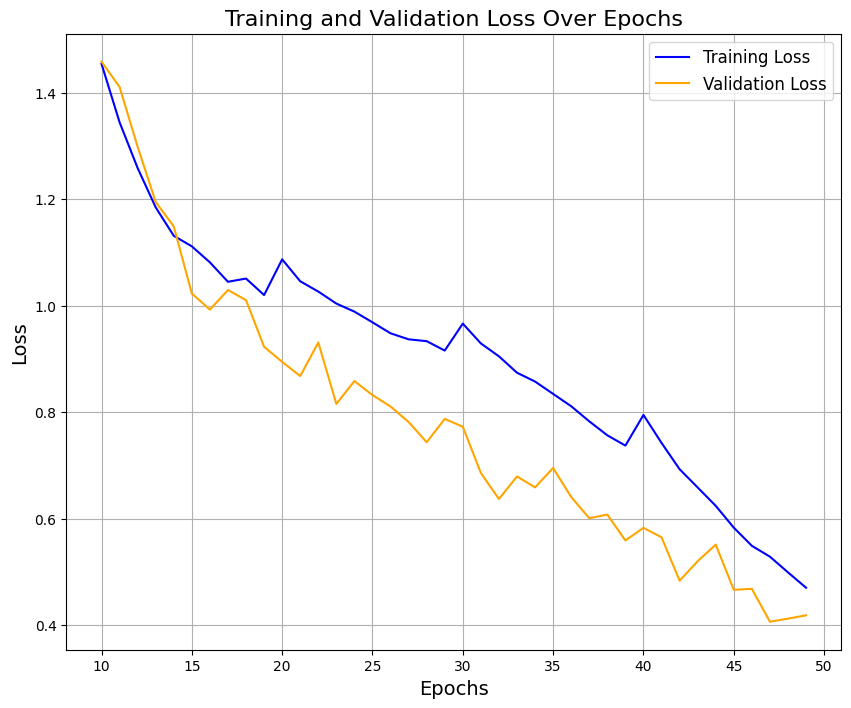

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 8))
plt.plot(range(10, len(train_loss_list) + 10), train_loss_list, label="Training Loss", color='blue')
plt.plot(range(10, len(val_loss_list) + 10), val_loss_list, label="Validation Loss", color='orange')

# Add titles and labels
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)


plt.savefig('loss_over_epochs.png', dpi=300)
plt.show()


# Getting the Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
import torch


solver.net.eval()

val_accuracy = 0


val_data_loader_iter = iter(val_loader)
for val_img, val_mask in val_data_loader_iter:

    solver.set_input(val_img, val_mask)

    predicted_mask, _ = solver.test_batch()
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)


    predicted_mask = torch.tensor(predicted_mask).to(torch.float32)


    val_accuracy += accuracy_score(val_mask.cpu().numpy().flatten(),
                                   predicted_mask.cpu().numpy().flatten())

val_accuracy /= len(val_data_loader_iter)


print(f'Validation Accuracy: {val_accuracy:.4f}')




Validation Accuracy: 0.9454


<ipython-input-3-e6f3aa0d42e4>:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.img = V(self.img.to(self.device), volatile=volatile)
<ipython-input-3-e6f3aa0d42e4>:63: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.mask = V(self.mask.to(self.device), volatile=volatile)


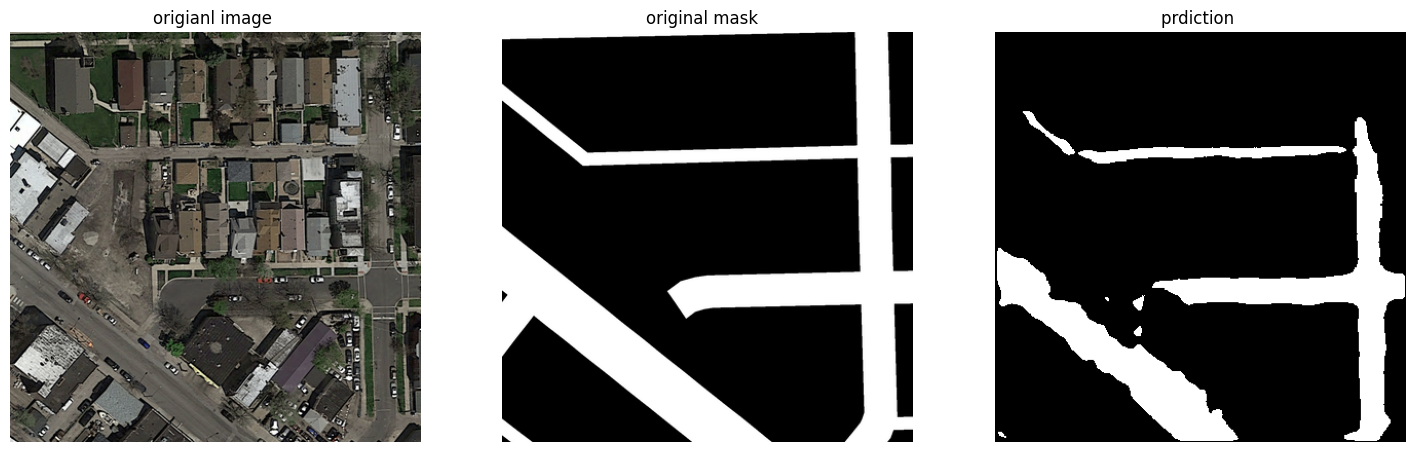

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def decode_segmentation(mask):
    colors = {
        0: [0, 0, 0],
        1: [255, 255, 255]
    }
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for label, color in colors.items():
        rgb[mask == label] = color
    return rgb

model = LightCUNet().to(device)
model.load_state_dict(torch.load('weights/best_LightCUNet.th'))

val_transform = A.Compose([
    A.Resize(384, 384),
    A.Normalize(),
    ToTensorV2()
])

sample_idx = 20
sample_image_path = os.path.join(image_root, image_list[sample_idx])
sample_mask_path = os.path.join(gt_root, gt_list[sample_idx])

sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
orig_h, orig_w, _ = sample_image.shape

true_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

aug = val_transform(image=sample_image)
input_tensor = aug["image"].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred_mask = model(input_tensor)
pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()
binary_pred = (pred_mask > 0.7).astype(np.uint8)

pred_resized = cv2.resize(binary_pred, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("origianl image ")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("original mask  ")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decode_segmentation(pred_resized))
plt.title("prdiction ")
plt.axis("off")

plt.show()

# Getting the files for submition

In [ ]:
test() # calling the function that predicts the test_set_images file and gives us a label for each of them

0.0      0.00
Testing on  test_1.png
Testing on  test_10.png
Testing on  test_11.png
Testing on  test_12.png
Testing on  test_13.png
Testing on  test_14.png
Testing on  test_15.png
Testing on  test_16.png
Testing on  test_17.png
Testing on  test_18.png
1.0      11.03
Testing on  test_19.png
Testing on  test_2.png
Testing on  test_20.png
Testing on  test_21.png
Testing on  test_22.png
Testing on  test_23.png
Testing on  test_24.png
Testing on  test_25.png
Testing on  test_26.png
Testing on  test_27.png
2.0      22.21
Testing on  test_28.png
Testing on  test_29.png
Testing on  test_3.png
Testing on  test_30.png
Testing on  test_31.png
Testing on  test_32.png
Testing on  test_33.png
Testing on  test_34.png
Testing on  test_35.png
Testing on  test_36.png
3.0      33.47
Testing on  test_37.png
Testing on  test_38.png
Testing on  test_39.png
Testing on  test_4.png
Testing on  test_40.png
Testing on  test_41.png
Testing on  test_42.png
Testing on  test_43.png
Testing on  test_44.png
Testing o

In [ ]:



import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(full_path, image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(full_path)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, submission_mask_path, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            path = os.path.join(submission_mask_path, fn)
            f.writelines('{}\n'.format(s)
                         for s in mask_to_submission_strings(path, fn))


def submit():
    submission_filename = 'LightCUNet.csv'
    submission_mask_path = 'submits/LightCUNet/'
    end = int(len('_mask.png'))
    start = int(len('test_'))
    image_names = os.listdir(submission_mask_path)
    image_names.sort(key=lambda x: int(x[start:][:-end]))
    masks_to_submission(submission_filename, submission_mask_path, image_names)


In [ ]:
submit()